<!-- clustering_llm
├─ data
│  ├─ data.rar
├─ img
├─ embedding.ipynb
├─ embedding_creation.py
├─ kmeans.ipynb
├─ kprototypes.ipynb
├─ README.md
└─ requirements.txt
 -->

In [20]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

In [21]:
df = pd.read_csv("data/train.csv", sep = ";")
df = df.iloc[:, 0:8]

In [22]:
df.head()

age           job  marital  education default  balance housing loan
0   58    management  married   tertiary      no     2143     yes   no
1   44    technician   single  secondary      no       29     yes   no
2   33  entrepreneur  married  secondary      no        2     yes  yes
3   47   blue-collar  married    unknown      no     1506     yes   no
4   33       unknown   single    unknown      no        1      no   no

## Method 1: K-Means

### Preprocessed

A preprocessing of the variables is carried out:

1. It consists of converting categorical variables into numeric ones. We are going to apply Onehot encoder for the nominal variables and a OrdinalEncoder for the ordinals features (education).
2. We try to ensure that the numerical variables have a Gaussian distribution. For them we will apply a PowerTransformer.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_transformer_onehot = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output =False))
        
    ])

categorical_transformer_ordinal = Pipeline(
    steps=[
        ('encoder', OrdinalEncoder())
        
    ])

num = Pipeline(
    steps=[
        ('encoder', PowerTransformer())
        
    ])

preprocessor  = ColumnTransformer(transformers = [
                                        ('cat_onehot', categorical_transformer_onehot, ["default", "housing", "loan", "job", "marital"]),
                                        ('cat_ordinal', categorical_transformer_ordinal, ["education"]),
                                        ('num', num, ["age", "balance"])
                                        ])
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor)]
    )
pipe_fit = pipeline.fit(df)

data = pd.DataFrame(pipe_fit.transform(df), columns = pipe_fit.get_feature_names_out().tolist())

In [24]:
pipe_fit.get_feature_names_out().tolist()

['cat_onehot__default_yes',
 'cat_onehot__housing_yes',
 'cat_onehot__loan_yes',
 'cat_onehot__job_blue-collar',
 'cat_onehot__job_entrepreneur',
 'cat_onehot__job_housemaid',
 'cat_onehot__job_management',
 'cat_onehot__job_retired',
 'cat_onehot__job_self-employed',
 'cat_onehot__job_services',
 'cat_onehot__job_student',
 'cat_onehot__job_technician',
 'cat_onehot__job_unemployed',
 'cat_onehot__job_unknown',
 'cat_onehot__marital_married',
 'cat_onehot__marital_single',
 'cat_ordinal__education',
 'num__age',
 'num__balance']

In [25]:
data.columns.tolist()

['cat_onehot__default_yes',
 'cat_onehot__housing_yes',
 'cat_onehot__loan_yes',
 'cat_onehot__job_blue-collar',
 'cat_onehot__job_entrepreneur',
 'cat_onehot__job_housemaid',
 'cat_onehot__job_management',
 'cat_onehot__job_retired',
 'cat_onehot__job_self-employed',
 'cat_onehot__job_services',
 'cat_onehot__job_student',
 'cat_onehot__job_technician',
 'cat_onehot__job_unemployed',
 'cat_onehot__job_unknown',
 'cat_onehot__marital_married',
 'cat_onehot__marital_single',
 'cat_ordinal__education',
 'num__age',
 'num__balance']

In [26]:
data.head()

cat_onehot__default_yes  cat_onehot__housing_yes  cat_onehot__loan_yes  \
0                      0.0                      1.0                   0.0   
1                      0.0                      1.0                   0.0   
2                      0.0                      1.0                   1.0   
3                      0.0                      1.0                   0.0   
4                      0.0                      0.0                   0.0   

   cat_onehot__job_blue-collar  cat_onehot__job_entrepreneur  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           1.0   
3                          1.0                           0.0   
4                          0.0                           0.0   

   cat_onehot__job_housemaid  cat_onehot__job_management  \
0                        0.0                         1.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   cat_onehot__job_retired  cat_onehot__job_self-employed  \
0                      0.0                            0.0   
1                      0.0                            0.0   
2                      0.0                            0.0   
3                      0.0                            0.0   
4                      0.0                            0.0   

   cat_onehot__job_services  cat_onehot__job_student  \
0                       0.0                      0.0   
1                       0.0                      0.0   
2                       0.0                      0.0   
3                       0.0                      0.0   
4                       0.0                      0.0   

   cat_onehot__job_technician  cat_onehot__job_unemployed  \
0                         0.0                         0.0   
1                         1.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   cat_onehot__job_unknown  cat_onehot__marital_married  \
0                      0.0                          1.0   
1                      0.0                          0.0   
2                      0.0                          1.0   
3                      0.0                          1.0   
4                      1.0                          0.0   

   cat_onehot__marital_single  cat_ordinal__education  num__age  num__balance  
0                         0.0                     2.0  1.473637      0.414773  
1                         1.0                     1.0  0.429379     -0.410774  
2                         0.0                     1.0 -0.709873     -0.431122  
3                         0.0                     3.0  0.683128      0.197685  
4                         1.0                     3.0 -0.709873     -0.432119

### Outliers
It is crucial that there are as few outliers in our data as Kmeans is very sensitive to this. We can apply the typical method of choosing outliers using the z score, but we will use the **Python Outlier Detection (PyOD)** library. This library is focused on detecting outliers for different cases. To be more specific we will use the **ECOD method (“empirical cumulative distribution functions for outlier detection”)**.

**This method seeks to obtain the distribution of the data and thus know which are the values ​​where the probability density is lower (outliers).**

In [27]:
from pyod.models.ecod import ECOD

clf = ECOD()
clf.fit(data)
outliers = clf.predict(data)

data['outliers'] = outliers
df["outliers"] = outliers

# Data without outliers
data_no_outliers = data[data['outliers'] == 0]
data_no_outliers = data_no_outliers.drop(['outliers'], axis = 1)

# Data without outliers
data_with_outliers = data.copy()
data_with_outliers = data_with_outliers.drop(['outliers'], axis = 1)

# Original Data with Outliers
df_no_outliers = df[df["outliers"] == 0]
df_no_outliers = df_no_outliers.drop(["outliers"], axis = 1)

print(data_no_outliers.shape)
print(data_with_outliers.shape)
print(df_no_outliers.shape)

(40690, 19)
(45211, 19)
(40690, 8)


### Modeling

One of the disadvantages of using the Kmeans algorithm is that you must choose the number of clusters you want to use. In this case, in order to obtain that data, we will use Elbow Method. It consists of calculating the distortion that exists between the points of a cluster and its centroid. The objective is clear, to obtain the least possible distortion. In this case we use the following code:

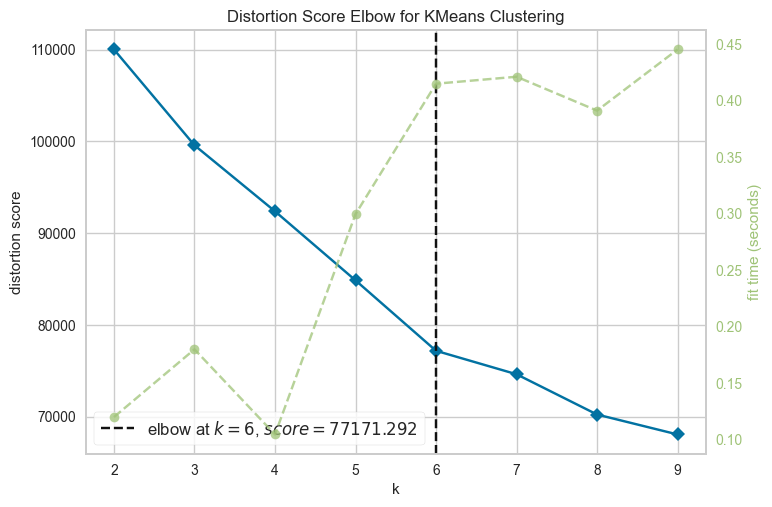

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(init = "k-means++", random_state=0, n_init="auto")
visualiser = KElbowVisualizer(km, k = (2,10))

# fit the data
visualiser.fit(data_no_outliers)
visualiser.show()

We see that from k=6, the distortion does not vary drastically. It is true that the ideal is that the behavior starting from k= 6 would be almost flat. This rarely happens and other methods can be applied to be sure of the most optimal number of clusters. To be sure, we could perform a Silhoutte visualization. The code is the following:

In [29]:
# def make_Silhouette_plot(X, n_clusters):
#     plt.xlim([-0.1, 1])
#     plt.ylim([0, len(X) + (n_clusters + 1) * 10])
#     clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
#     cluster_labels = clusterer.fit_predict(X)
#     silhouette_avg = silhouette_score(X, cluster_labels)
#     print(
#         "For n_clusters =", n_clusters,
#         "The average silhouette_score is :", silhouette_avg,
#     )
# # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)
#     y_lower = 10
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#         ith_cluster_silhouette_values.sort()
#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
#         color = cm.nipy_spectral(float(i) / n_clusters)
#         plt.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )
#         plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#         y_lower = y_upper + 10
#         plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
#         plt.xlabel("The silhouette coefficient values", fontsize=24)
#         plt.ylabel("Cluster label", fontsize=24)
#         plt.axvline(x=silhouette_avg, color="red", linestyle="--")
#         plt.yticks([])  
#         plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
# range_n_clusters = list(range(2,10))
# for n_clusters in range_n_clusters:
#     print(f"N cluster: {n_clusters}")
#     make_Silhouette_plot(data_no_outliers, n_clusters)   
#     plt.savefig('Silhouette_plot/Silhouette_plot_{}.png'.format(n_clusters))
#     plt.close()

<div style="display: flex; justify-content: space-between;">
    <img src="Silhouette_plot/Silhouette_plot_2.png" alt="Alt text" width="400"/>
    <img src="Silhouette_plot/Silhouette_plot_5.png" alt="Alt text" width="400"/>
    <img src="Silhouette_plot/Silhouette_plot_8.png" alt="Alt text" width="400"/>
</div>

<div style="display: flex; justify-content: space-between;">
    <img src="Silhouette_plot/Silhouette_plot_3.png" alt="Alt text" width="400"/>
    <img src="Silhouette_plot/Silhouette_plot_6.png" alt="Alt text" width="400"/>
    <img src="Silhouette_plot/Silhouette_plot_9.png" alt="Alt text" width="400"/>
</div>

<div style="display: flex; justify-content: space-between;">
    <img src="Silhouette_plot/Silhouette_plot_4.png" alt="Alt text" width="400"/>
    <img src="Silhouette_plot/Silhouette_plot_7.png" alt="Alt text" width="400"/>
</div>

**The best number here is 4 to 5**

In [30]:
km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=100, random_state=42)
clusters_predict = km.fit_predict(data_no_outliers)
print(km.inertia_)

81380.95508928494


### Evaluation
The way of evaluating kmeans models is somewhat more open than for other models. We can use:
* metrics
* visualizations
* interpretation (Something very important for companies).

In relation to the **model evaluation metrics**, we can use the following code:

In [31]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure 
of each cluster with its most similar cluster, where similarity 
is the ratio of within-cluster distances to between-cluster distances.

The minimum value of the DB Index is 0, whereas a smaller 
value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(data_no_outliers,clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.

Calinski Harabaz Index is defined as the ratio of the 
sum of between-cluster dispersion and of within-cluster dispersion.

The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(data_no_outliers,clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of 
fit of a clustering algorithm, but can also be used as 
a method for determining an optimal value of k (see here for more).

Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either
the data or the value of k is incorrect.

1 is the ideal value and indicates that clusters are very 
dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(data_no_outliers,clusters_predict)}")

Davies bouldin score: 1.676769775662788
Calinski Score: 6914.705500337112
Silhouette Score: 0.16729335453306268


As far as can be shown, we do not have an excessively good model. Davies’ score is telling us that the distance between clusters is quite small.

This may be due to several factors, but keep in mind that the energy of a model is the data; if the data does not have sufficient predictive power, you cannot expect to achieve exceptional results.

For **visualizations**, we can use the method to **reduce dimensionality, PCA**. For them we are going to use the Prince library, focused on exploratory analysis and dimensionality reduction. If you prefer, you can use Sklearn’s PCA, they are identical.
First we will calculate the principal components in 3D, and then we will make the representation. These are the two functions performed by the previous steps:

In [32]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()

    fig = px.scatter_3d(df, 
                        x=columns[0], 
                        y=columns[1], 
                        z=columns[2],
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()


    fig = px.scatter(df, 
                        x=columns[0], 
                        y=columns[1],
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()

In [33]:
## %matplotlib inline
## import plotly.io as pio
## pio.renderers.default = 'notebook'

pca_3d_object, df_pca_3d = get_pca_3d(data_no_outliers, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)


/Users/luther/.local/share/virtualenvs/customer_segmentation-eqxHvxcv/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



When the above is rendered, it can be seen that the clusters have almost no separation between them and there is no clear division. This is in accordance with the information provided by the metrics.

    Something to keep in mind and that very few people keep in mind is the PCA and the variability of the eigenvectors.

Let’s say that each field contains a certain amount of information, and this adds its bit of information. If the accumulated sum of the 3 main components adds up to around 80% variability, we can say that it is acceptable, obtaining good results in the representations. If the value is lower, we have to take the visualizations with a grain of salt since we are missing a lot of information that is contained in other eigenvectors.

    The next question is obvious: What is the variability of the PCA executed?
    
The answer is the following:

In [34]:
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.245        11.81%                     11.81%
1              1.774         9.34%                     21.15%
2              1.298         6.83%                     27.98%


As can be seen, we have 27.98% variability with the first 3 components, something insufficient to draw informed conclusions.

When we apply the PCA method, since it is a linear algorithm, it is not capable of capturing more complex relationships. Luckily there is a method called **t-SNE**, which is capable of capturing **these complex polynomial relationships**. This can help us visualize, since with the previous method we have not had much success.

Keep in mind that it has a higher computational cost. For this reason, I sampled my original dataset and it still took me about 5 minutes to get the result. The code is as follows:

In [40]:
from sklearn.manifold import TSNE

sampling_data = data_no_outliers.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
                  n_components=3, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "PCA Space", opacity=1, width_line = 0.1)

/Users/luther/.local/share/virtualenvs/customer_segmentation-eqxHvxcv/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



When the above is rendered, It shows a clearer separation between clusters but unfortunately, we still don’t have good results.

Finally, let’s explore a little how the model works, in which features are the most important and what are the main characteristics of the clusters.

To see the importance of each of the variables we will use a typical “trick” in this type of situation. We are going to create a classification model where the “X” is the inputs of the Kmeans model, and the “y” is the clusters predicted by the Kmeans model.

The chosen model is an LGBMClassifier. This model is quite powerful and works well having categorical and numerical variables. Having the new model trained, using the SHAP library, we can obtain the importance of each of the features in the prediction. The code is:

In [36]:
import lightgbm as lgb
import shap


clf_km = lgb.LGBMClassifier(colsample_bytree=0.8)



for col in ["job", "marital", "education", "housing", "loan", "default"]:
    df_no_outliers[col] = df_no_outliers[col].astype('category')


# clf_km.fit(X = df_no_outliers , y = clusters_predict, feature_name = "auto", categorical_feature = "auto")
# clf_km.fit(X = df_prueba, y = predict_embedding, feature_name='auto', categorical_feature = 'auto')

In [37]:
clf_km.fit(X = df_no_outliers , y = clusters_predict, feature_name = "auto", categorical_feature = "auto")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 40690, number of used features: 8
[LightGBM] [Info] Start training from score -1.623919
[LightGBM] [Info] Start training from score -1.413347
[LightGBM] [Info] Start training from score -1.489718
[LightGBM] [Info] Start training from score -2.816857
[LightGBM] [Info] Start training from score -1.293467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.8)

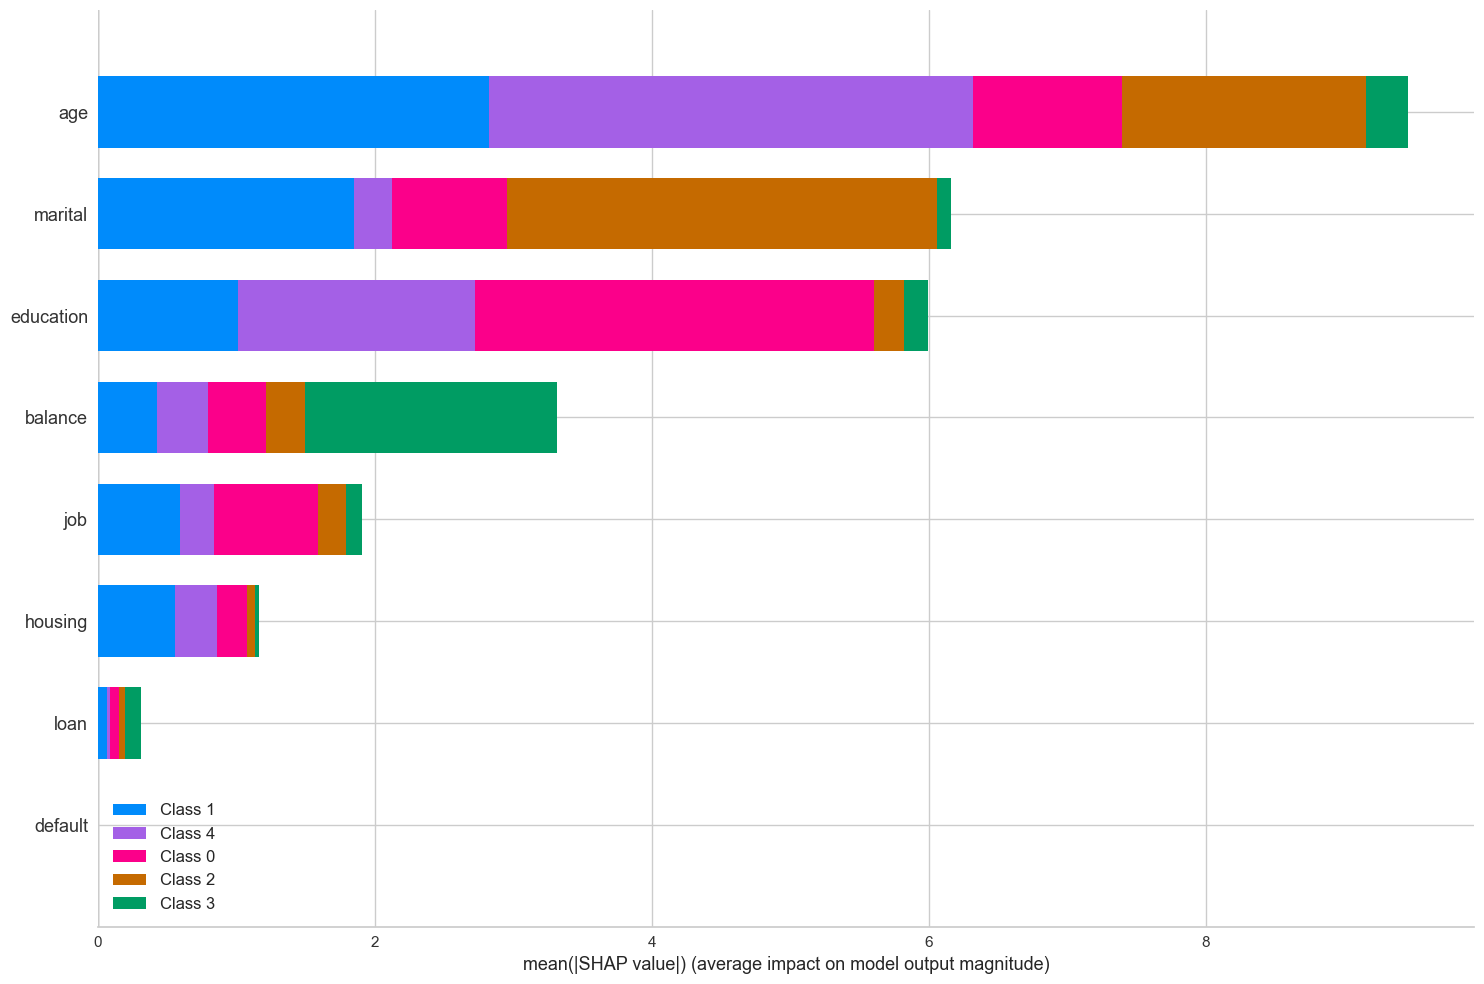

In [38]:
#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(df_no_outliers)
shap.summary_plot(shap_values_km, df_no_outliers, plot_type="bar", plot_size=(15, 10))

It can be seen that feature age has the greatest predictive power. It can also be seen that cluster number 3 (green) is mainly differentiated by the balance variable.

Finally we must analyze the characteristics of the clusters. This part of the study is what is decisive for the business. For them we are going to obtain the means (for the numerical variables) and the most frequent value (categorical variables) of each of the features of the dataset for each of the clusters:

In [39]:
df_no_outliers = df[df.outliers == 0]
df_no_outliers["cluster"] = clusters_predict

df_no_outliers.groupby('cluster').agg(
    {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        # 'contact': lambda x: x.value_counts().index[0],
        'age':'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0],
        
    }
).sort_values("age").reset_index()

/var/folders/c4/00mqvhcj3x50fgqmlfwv9yk80000gn/T/ipykernel_18763/1509487301.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster          job  marital  education housing loan        age  \
0        2   technician   single  secondary     yes   no  32.069443   
1        1  blue-collar  married  secondary     yes   no  34.584789   
2        3   management  married  secondary     yes   no  42.145910   
3        0   management  married   tertiary      no   no  43.740556   
4        4  blue-collar  married  secondary      no   no  50.235083   

       balance default  
0   793.211272      no  
1   591.974043      no  
2  7532.461159      no  
3   873.011096      no  
4   838.415965      no

We see that the clusters with **job=blue-collar** do not have a great differentiation between their characteristics, except by the age feature. This is something that is not desirable since it is difficult to differentiate the clients of each of the clusters. In the **job=management** case, we obtain better differentiation.
After carrying out the analysis in different ways, they converge on the same conclusion: **We need to improve the results**.